/tmp/ipykernel_1626846/3801325049.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["labels"] = df2["labels"].map({-1: 0, 0: 1, 1: 2})
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.537300,0.672632,0.739130
2,0.262600,0.861780,0.782609
3,0.179400,0.628426,0.869565
4,0.050500,0.861219,0.847826
5,0.035600,0.887512,0.869565
6,0.027900,0.899707,0.869565
7,0.045000,0.950229,0.847826
8,0.039400,0.944299,0.847826
9,0.022500,0.958504,0.847826
10,0.020200,0.960922,0.847826


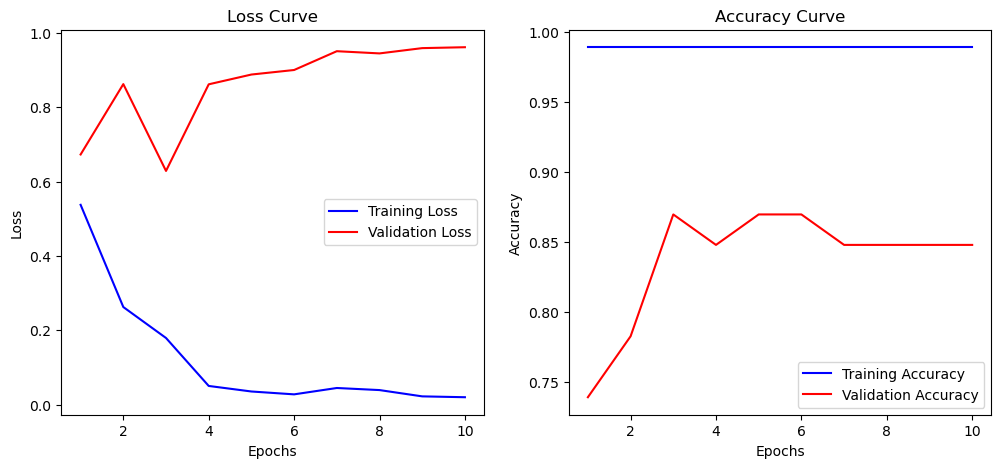

Label Distribution in Training Set:
labels
0     10
1    119
2     51
Name: count, dtype: int64

Label Distribution in Test Set:
labels
0     4
1    32
2    10
Name: count, dtype: int64

Total Samples Used: 226


In [17]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from safetensors.torch import save_file, load_file
import pickle

# Load and prepare the dataset
def load_and_prepare_data(file_path, journal):
    if journal == "TPT":
        df = pd.read_csv(file_path)
    elif journal == "AJP":
        with open(file_path, 'rb') as file:
            df = pickle.load(file)
            df = df.rename(columns={'sentiment_human': "labels", 'ex_sent': "text"})
    df2 = df[df["labels"] != -9999]
    df2["labels"] = df2["labels"].map({-1: 0, 0: 1, 1: 2})   
    return df2

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=128)

fileloc = "df_ajp_merged.pkl"
data = load_and_prepare_data(fileloc, "AJP")

# Split data into training and testing
train_df, test_df = train_test_split(data, test_size=0.2, train_size=0.8)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=3)

# Convert to Hugging Face Dataset
datasets = {
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
}

encoded_datasets = {key: ds.map(tokenize_function, batched=True) for key, ds in datasets.items()}

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy='epoch',
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Track loss and accuracy
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and save loss/accuracy after each epoch
trainer.train()

# Track loss and accuracy after each epoch
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for log in trainer.state.log_history:
    if "loss" in log:  # Training loss is logged during training
        train_loss.append(log["loss"])
    if "eval_loss" in log:  # Validation loss and accuracy are logged during evaluation
        val_loss.append(log["eval_loss"])
        val_acc.append(log["eval_accuracy"])

# Get training accuracy at each epoch
for epoch in range(len(train_loss)):
    train_results = trainer.evaluate(eval_dataset=encoded_datasets["train"])
    train_acc.append(train_results["eval_accuracy"])
# P
# Plot loss and accuracy
epochs = range(1, training_args.num_train_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# Print class distributions
train_counts = train_df["labels"].value_counts().sort_index()
test_counts = test_df["labels"].value_counts().sort_index()

total_samples = len(data)
print("Label Distribution in Training Set:")
print(train_counts)
print("\nLabel Distribution in Test Set:")
print(test_counts)
print(f"\nTotal Samples Used: {total_samples}")


In [16]:
train_loss.append(train_metrics.training_loss) #This records the average of all the training steps losses, which would work if the loop varied the number of epochs, which it does not. The number of epochs should be updated every run and this number will then be correct. 
val_metrics = trainer.evaluate()
print(val_metrics["eval_loss"])
print(train_metrics.metrics["train_loss"]) ##Problem:  This is saving the "train_loss" value to the training accuracy list. 
print(val_metrics["eval_accuracy"])
print(val_metrics)

trainer.

0.8465811610221863
0.030038591182750204
0.8913043478260869
{'eval_loss': 0.8465811610221863, 'eval_accuracy': 0.8913043478260869, 'eval_runtime': 0.0657, 'eval_samples_per_second': 699.672, 'eval_steps_per_second': 91.262, 'epoch': 10.0}


In [ ]:
# Evaluate on the test dataset (default behavior)
test_results = trainer.evaluate(eval_dataset=encoded_datasets["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']*100:.2f}%")

# Evaluate on the training dataset (optional)
train_results = trainer.evaluate(eval_dataset=encoded_datasets["train"])
print(f"Training Accuracy: {train_results['eval_accuracy']*100:.2f}%")

In [9]:
# Evaluate on the test dataset (default behavior)
test_results = trainer.evaluate(eval_dataset=encoded_datasets["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']*100:.2f}%")

# Evaluate on the training dataset (optional)
train_results = trainer.evaluate(eval_dataset=encoded_datasets["train"])
print(f"Training Accuracy: {train_results['eval_accuracy']*100:.2f}%")

Test Accuracy: 83.93%
Training Accuracy: 87.00%


In [10]:
def classify_sentiment(model, tokenizer, sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the GPU
    inputs = tokenizer(sentence, return_tensors="pt").to(device)  # Move input tensors to the GPU

    with torch.no_grad():  # No need for gradient computation during inference
        outputs = model(**inputs)

    logits = outputs.logits  # Extract logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)  # Convert logits to probabilities
    predicted_class = probabilities.argmax().item()  # Get the highest probability class

    label_map = {0: "negative", 1: "neutral", 2: "positive"}  # Adjust based on model's labels

    print(probabilities)
    return label_map[predicted_class], probabilities

# Example usage:
sentence = "Active learning is a buzz word that means nothing."
sentiment, probs = classify_sentiment(model, tokenizer, sentence)
print(f"Sentiment: {sentiment}")

tensor([[0.4001, 0.5742, 0.0257]])
Sentiment: neutral


In [49]:
#######Okie doke, I don't think this will work if loading in after the fact. I think you need to train the lora before you train the model? 


from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
import random
randint=random.randint(0,100)
torch.manual_seed(randint)
print(randint)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["classifier.dense", "classifier.out_proj"],
    lora_dropout=0.1,
    bias="none"
)

lora_model = get_peft_model(model, lora_config)

#Defining the training args for the lora layer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy='epoch',
    save_strategy="epoch",
    learning_rate=1e-6, #changed from 2e-5
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=epoch,
    weight_decay=0.07,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Apply LoRA modifications
#lora_model = get_peft_model(model, lora_config)

# Load the LoRA adapter weights
state_dict = load_file("trained_model_roberta_accurate.safetensors")
#lora_model.load_state_dict(state_dict, strict=False)
#lora_model.enable_adapter_layers()

print("LoRA model loaded successfully from safetensors.")


for name, param in lora_model.named_parameters():
    if "lora" in name:
        param.data += torch.randn_like(param.data) * 0.05  # Small random perturbation
        torch.rand(random.randint(1,100))
    #torch.seed()
# Evaluate the model after loading
results = trainer.evaluate()
accuracy = results["eval_accuracy"] * 100
print(f"Test Accuracy after loading: {accuracy:.2f}%")

/home/f52r714/.conda/envs/lang_4/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


35
LoRA model loaded successfully from safetensors.


Test Accuracy after loading: 83.93%


In [18]:
datasets['test']['labels'].count(0)

1

In [ ]:
#